In [23]:
import pandas as pd

In [24]:
df=pd.read_csv("/home/aditi/python_projects/Minor/separation.csv")

In [45]:
df

,Category,Reviews,category_id
0,Faculty,Some teachers are really helpful and will try ...,0
1,Faculty,The teachers are qualified and somewhat knowle...,0
2,Faculty,The teachers are decently qualified and knowle...,0
3,Faculty,Many faculty members in our college are PhD ho...,0
4,Faculty,Faculty members in our college are okay but no...,0
5,Faculty,"Our faculty members are good, and most of the ...",0
6,Faculty,Faculty is also good and helping. Only a few a...,0
7,Faculty,Faculty members in the college are not up to t...,0
8,Faculty,"Faculty members of the college are the best, b...",0
9,Faculty,All the professors are highly knowledgeable as...,0


In [46]:
print(df["Reviews"].loc[1])
print(df["Reviews"].loc[913])

The teachers are qualified and somewhat knowledgeable. Some are helpful but not everyone. Teaching quality varies from teacher to teacher 
Some teachers make very much efforts to make us understand the topic but some are there only because they have to be. 
How were placements for your batch and your senior batch? What per cent of students were placed? What was the highest, the lowest and average salary offered? Which all companies visited the campus? What kind of roles were offered to the students How were placements for your batch and your senior batch? What per cent of students were placed? What was the highest, the lowest and average salary offered? Which all companies visited the campus? What kind of roles were offered to the students.


In [27]:
from io import StringIO
col = ['Category', 'Reviews']
df = df[col]
df = df[pd.notnull(df['Reviews'])]
df.columns = ['Category', 'Reviews']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Reviews,category_id
0,Faculty,Some teachers are really helpful and will try ...,0
1,Faculty,The teachers are qualified and somewhat knowle...,0
2,Faculty,The teachers are decently qualified and knowle...,0
3,Faculty,Many faculty members in our college are PhD ho...,0
4,Faculty,Faculty members in our college are okay but no...,0


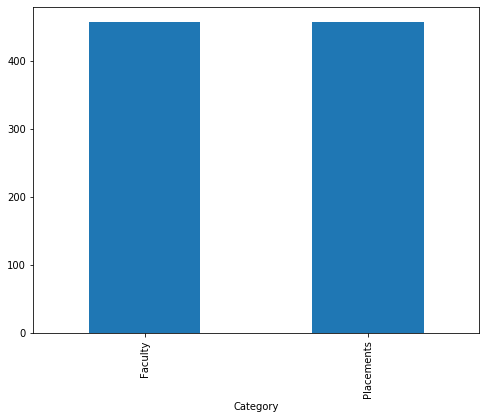

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Reviews.count().plot.bar(ylim=0)
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Reviews).toarray()
labels = df.category_id
features.shape

(914, 1162)

In [30]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Faculty':
  . Most correlated unigrams:
. companies
. faculty
  . Most correlated bigrams:
. course curriculum
. faculty members
# 'Placements':
  . Most correlated unigrams:
. companies
. faculty
  . Most correlated bigrams:
. course curriculum
. faculty members


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [47]:
print(clf.predict(count_vect.transform(["How were placements for your batch and your senior batch? What per cent of students were placed? What was the highest, the lowest and average salary offered? Which all companies visited the campus? What kind of roles were offered to the students How were placements for your batch and your senior batch? What per cent of students were placed? What was the highest, the lowest and average salary offered? Which all companies visited the campus? What kind of roles were offered to the students."])))

['Placements']


/home/aditi/python_projects/python_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aditi/python_projects/python_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aditi/python_projects/python_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aditi/python_projects/python_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aditi/python_projects/python_env/lib/python3.6/site-packages/sklearn/linea

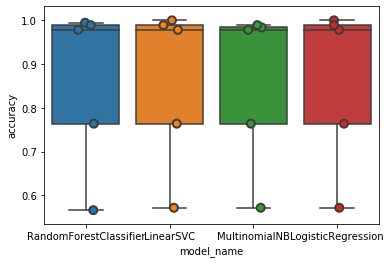

In [43]:


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [44]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.860487
LogisticRegression        0.860487
MultinomialNB             0.857226
RandomForestClassifier    0.858301
Name: accuracy, dtype: float64

In [48]:
import pandas as pd
import nltk 
import re 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import tokenize

In [49]:
df=pd.read_csv("/home/aditi/python_projects/Minor/JIITcombined.csv")

In [50]:
df["Accomodation/Infrastructure"]=df["Infrastructure"]
df["Placements"]=df["Placement"]

In [51]:
del df["Placement"]
del df["Infrastructure"]

In [52]:
df.replace(["<p>","<br>","-","()","(",")","..","..."], 
                     ["","","","","","","",""]) 

,Accomodation/Infrastructure,Faculty,Label,Other,Placements,Rating,Review,Social,Title,Website
0,NaN,NaN,NaN,NaN,NaN,90.0,I am a PhD student and about to submit my thes...,NaN,Focus on quality work,career
1,NaN,NaN,NaN,NaN,NaN,100.0,Jaypee is one of the best engineering college ...,NaN,My view on jaypee,career
2,NaN,NaN,NaN,NaN,NaN,100.0,jaypee is a excellent college for computer sci...,NaN,Best private college in North india,career
3,NaN,NaN,NaN,NaN,NaN,80.0,The infrastructure of the college is good. it ...,NaN,My words on jaypee institute of information te...,career
4,NaN,NaN,NaN,NaN,NaN,90.0,Jaypee sec 62 is a decent college with student...,NaN,Highly competitive Environment,career
5,NaN,NaN,NaN,NaN,NaN,80.0,Presently i m in 2nd year btech computer scien...,NaN,Overall a good college .,career
6,NaN,NaN,NaN,NaN,NaN,70.0,The infrastructure of the institute is worth l...,NaN,One of the best pvt. engineering college in NCR,career
7,NaN,NaN,NaN,NaN,NaN,100.0,"JIIT, Noida has well-built infrastructure. It ...",NaN,"Great College, go for it",career
8,NaN,NaN,NaN,NaN,NaN,70.0,Jiit is an amazing college. Not only it is loc...,NaN,Life in JIIT,career
9,NaN,NaN,NaN,NaN,NaN,70.0,"College life in jaypee is great, you meet new ...",NaN,College life at JIIT,career


In [62]:
for i in range (0,828):
    text=df["Review"].values[i]
    l=tokenize.sent_tokenize(text)
    
    
    for sentence in l:
        string=clf.predict(count_vect.transform([sentence]))
        
        if string==['Infrastructure']:
            df['Accomodation/Infrastructure'].loc[i]=sentence
            
        elif string==['Faculty']:
            df['Faculty'].loc[i]=sentence
            
        elif string==['Placements']:
            df['Placements'].loc[i]=sentence
    

In [63]:
df

,Accomodation/Infrastructure,Faculty,Label,Other,Placements,Rating,Review,Social,Title,Website
0,NaN,"So, I can assure once you do your research wor...",NaN,NaN,NaN,90.0,I am a PhD student and about to submit my thes...,NaN,Focus on quality work,career
1,NaN,NaN,NaN,NaN,Highest package is 48 lakh in 2017 and average...,100.0,Jaypee is one of the best engineering college ...,NaN,My view on jaypee,career
2,NaN,NaN,NaN,NaN,jaypee is a excellent college for computer sci...,100.0,jaypee is a excellent college for computer sci...,NaN,Best private college in North india,career
3,NaN,"Our faculty is so good they teach well, scorin...",NaN,NaN,"it was situated in the heart of NCR, the campu...",80.0,The infrastructure of the college is good. it ...,NaN,My words on jaypee institute of information te...,career
4,NaN,Also they have made use of available space wel...,NaN,NaN,Campus is small but hostels are good.,90.0,Jaypee sec 62 is a decent college with student...,NaN,Highly competitive Environment,career
5,NaN,Hostel facility here is well nd good maintannc...,NaN,NaN,Last but not least a good college for future s...,80.0,Presently i m in 2nd year btech computer scien...,NaN,Overall a good college .,career
6,NaN,The course is very well bifurcated including t...,NaN,NaN,People who come here to take a look become a g...,70.0,The infrastructure of the institute is worth l...,NaN,One of the best pvt. engineering college in NCR,career
7,NaN,"While iits, bits are much better than jiit.",NaN,NaN,"Jiit is much better college than any uptu, ipu...",100.0,"JIIT, Noida has well-built infrastructure. It ...",NaN,"Great College, go for it",career
8,NaN,It also encourages a lot of extra curricular a...,NaN,NaN,Overall its a college every student aspires to...,70.0,Jiit is an amazing college. Not only it is loc...,NaN,Life in JIIT,career
9,NaN,There are many clubs in the college for the st...,NaN,NaN,"Companies like amazon, Deloitte etc.",70.0,"College life in jaypee is great, you meet new ...",NaN,College life at JIIT,career
